# Steering Sweep: Grade Level as Function of α

This notebook tests steering effectiveness by measuring output grade level across a range of α coefficients.

**Experiment design:**
- **Prompt:** "Please explain quantum mechanics. Please do not use Markdown."
- **Steering vector:** Wikipedia complexity vector (layer 34)
- **α sweep:** -1.0 to +1.0 in steps of 0.1 (21 points)
- **Output length:** 250 tokens (≈175 words, ~10 sentences)
- **Measurement:** Flesch-Kincaid Grade Level

**Hypothesis:** Grade level should increase monotonically with α, showing linear or near-linear relationship in some range.

## Configuration

In [1]:
# Model configuration
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'
DEVICE = 'auto'  # 'auto', 'cuda', 'mps', or 'cpu'

# Steering configuration
VECTOR_PATH = '../data/vectors/complexity_wikipedia.pt'
STEERING_LAYER = 35  # Best layer from extraction

# Experiment configuration
PROMPT = "Please explain quantum mechanics. Please do not use Markdown."
ALPHA_MIN = -1.0
ALPHA_MAX = 1.0
ALPHA_STEP = 0.1
MAX_NEW_TOKENS = 250  # Target ~175 words, ~10 sentences

# Generation parameters
TEMPERATURE = 0.0  # Standard sampling
TOP_P = 0.9       # Nucleus sampling
DO_SAMPLE = False  # Enable sampling (set False for deterministic)

## Setup

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm
import textstat

# Determine device
if DEVICE == 'auto':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using Apple Silicon GPU (MPS)")
    else:
        device = torch.device('cpu')
        print("⚠ Using CPU (this will be slow)")
else:
    device = torch.device(DEVICE)
    print(f"✓ Using device: {device}")

✓ Using Apple Silicon GPU (MPS)


## Load Model and Tokenizer

In [3]:
print(f"Loading model: {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

print(f"✓ Model loaded")
print(f"  Layers: {model.config.num_hidden_layers}")
print(f"  Hidden dim: {model.config.hidden_size}")

Loading model: Qwen/Qwen3-4B-Instruct-2507...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded
  Layers: 36
  Hidden dim: 2560


## Load Steering Vector

In [4]:
print(f"Loading steering vector from {VECTOR_PATH}...")
vector_data = torch.load(VECTOR_PATH, weights_only=False)

# Extract the steering vector for the specified layer
steering_vector = vector_data['vectors'][STEERING_LAYER].to(device).to(torch.bfloat16)

print(f"✓ Loaded steering vector")
print(f"  Layer: {STEERING_LAYER}")
print(f"  Shape: {steering_vector.shape}")
print(f"  Euclidean norm: {vector_data['layer_norms'][STEERING_LAYER]:.2f}")
print(f"  Dataset: {vector_data['metadata']['dataset']}")
print(f"  Extracted: {vector_data['metadata']['extraction_date'][:10]}")

Loading steering vector from ../data/vectors/complexity_wikipedia.pt...
✓ Loaded steering vector
  Layer: 35
  Shape: torch.Size([2560])
  Euclidean norm: 24.35
  Dataset: wikipedia
  Extracted: 2025-10-26


## Steering Hook Implementation

We'll use a forward hook to add `α·v` to the hidden states at the specified layer during generation.

In [5]:
# Global variable to hold current α value
current_alpha = 0.0

def steering_hook(module, input, output):
    """
    Forward hook that adds α·v to hidden states.
    
    Args:
        module: The layer module
        input: Tuple of input tensors
        output: Tuple of (hidden_states, ...) or just hidden_states
    
    Returns:
        Modified output with steering applied
    """
    # Extract hidden states (first element if tuple)
    if isinstance(output, tuple):
        hidden_states = output[0]
    else:
        hidden_states = output
    
    # Apply steering: h_new = h_old + α·v
    # v is [hidden_dim], broadcast across batch and sequence dimensions
    steered = hidden_states + current_alpha * steering_vector
    
    # Return in same format as input
    if isinstance(output, tuple):
        return (steered,) + output[1:]
    else:
        return steered

# Register hook on the specified layer
target_layer = model.model.layers[STEERING_LAYER]
hook_handle = target_layer.register_forward_hook(steering_hook)

print(f"✓ Steering hook registered on layer {STEERING_LAYER}")

✓ Steering hook registered on layer 35


## Generation Function

In [6]:
def generate_with_steering(prompt, alpha):
    """
    Generate text with specified steering coefficient.
    
    Args:
        prompt: Input text (will be formatted as user message)
        alpha: Steering coefficient
    
    Returns:
        Generated text (assistant response only, prompt removed)
    """
    global current_alpha
    current_alpha = alpha
    
    # Format prompt using chat template
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize formatted prompt
    inputs = tokenizer(formatted_prompt, return_tensors='pt').to(device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=TEMPERATURE,
            top_p=TOP_P,
            do_sample=DO_SAMPLE,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
        )
    
    # Decode full output
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract just the assistant's response (remove the formatted prompt)
    # The chat template adds special tokens, we want just the completion
    assistant_response = full_text.split("assistant\n")[-1].strip()
    
    return assistant_response

# Test generation at α=0 (no steering)
print("Testing generation at α=0 with chat template...")
test_output = generate_with_steering(PROMPT, alpha=0.0)
print(f"\n✓ Generated {len(test_output.split())} words")
print(f"\nPreview:\n{test_output[:200]}...")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Testing generation at α=0 with chat template...

✓ Generated 197 words

Preview:
Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the smallest scales—such as atoms, subatomic particles, and photons. Unlike classical physics, ...


## Run Steering Sweep

In [7]:
# Generate α values
alphas = np.arange(ALPHA_MIN, ALPHA_MAX + ALPHA_STEP/2, ALPHA_STEP)
print(f"Running steering sweep: {len(alphas)} α values from {ALPHA_MIN} to {ALPHA_MAX}")
print(f"Generating {MAX_NEW_TOKENS} tokens per α value\n")

# Store results
results = []

for alpha in tqdm(alphas, desc="Steering sweep"):
    # Generate (now returns just assistant response)
    completion = generate_with_steering(PROMPT, alpha)
    
    # Compute grade level
    try:
        grade_level = textstat.flesch_kincaid_grade(completion)
    except:
        grade_level = np.nan  # Handle edge cases
    
    # Count words and sentences
    n_words = len(completion.split())
    n_sentences = completion.count('.') + completion.count('!') + completion.count('?')
    
    # Store
    results.append({
        'alpha': float(alpha),
        'grade_level': grade_level,
        'n_words': n_words,
        'n_sentences': n_sentences,
        'completion': completion,
    })

# Convert to DataFrame
df = pd.DataFrame(results)

print(f"\n✓ Completed {len(df)} generations")
print(f"\nGrade level range: {df['grade_level'].min():.1f} to {df['grade_level'].max():.1f}")
print(f"Mean words per generation: {df['n_words'].mean():.1f}")

Running steering sweep: 21 α values from -1.0 to 1.0
Generating 250 tokens per α value



Steering sweep:   0%|          | 0/21 [00:00<?, ?it/s]


✓ Completed 21 generations

Grade level range: 10.5 to 14.3
Mean words per generation: 202.7


## Analyze Results

In [8]:
# Summary statistics
print("Summary by α:")
print(df[['alpha', 'grade_level', 'n_words', 'n_sentences']].to_string(index=False))

Summary by α:
        alpha  grade_level  n_words  n_sentences
-1.000000e+00    10.906552      212           11
-9.000000e-01    10.606802      215           11
-8.000000e-01    10.498645      214           11
-7.000000e-01    10.608925      214           11
-6.000000e-01    10.719206      214           11
-5.000000e-01    10.719206      214           11
-4.000000e-01    11.220941      197           11
-3.000000e-01    11.220941      197           11
-2.000000e-01    11.220941      197           11
-1.000000e-01    11.220941      197           11
-2.220446e-16    11.220941      197           11
 1.000000e-01    11.220941      197           11
 2.000000e-01    11.220941      197           11
 3.000000e-01    11.220941      197           11
 4.000000e-01    11.948887      196           10
 5.000000e-01    11.550408      196           11
 6.000000e-01    11.550408      196           11
 7.000000e-01    12.142277      202           12
 8.000000e-01    11.823553      197           12
 9.000

## Visualize Grade Level vs α

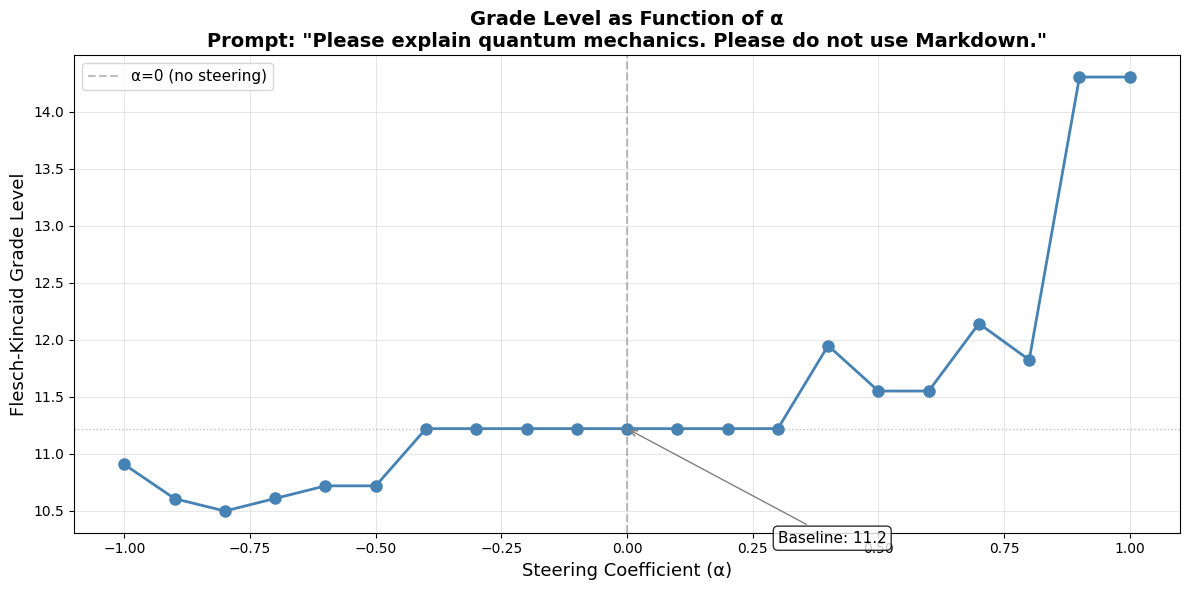


Linear regression:
  Grade Level = 11.50 + 1.31·α
  R² = 0.6194
  p-value = 2.31e-05

Interpretation:
  Each α unit changes grade level by 1.31 grades
  α=-1 to α=+1 spans 2.6 grade levels


In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot grade level vs alpha
ax.plot(df['alpha'], df['grade_level'], 'o-', linewidth=2, markersize=8, color='steelblue')

# Mark α=0 (baseline) - use tolerance for floating point comparison
baseline_idx = (df['alpha'].abs()).idxmin()  # Find closest to 0
baseline_grade = df.loc[baseline_idx, 'grade_level']
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='α=0 (no steering)')
ax.axhline(baseline_grade, color='gray', linestyle=':', alpha=0.5, linewidth=1)

# Labels and formatting
ax.set_xlabel('Steering Coefficient (α)', fontsize=13)
ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=13)
ax.set_title(f'Grade Level as Function of α\nPrompt: "{PROMPT}"', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Add annotation for baseline
ax.annotate(f'Baseline: {baseline_grade:.1f}', 
            xy=(0, baseline_grade), 
            xytext=(0.3, baseline_grade - 1),
            fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.show()

# Report linear fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df['alpha'], df['grade_level'])

print(f"\nLinear regression:")
print(f"  Grade Level = {intercept:.2f} + {slope:.2f}·α")
print(f"  R² = {r_value**2:.4f}")
print(f"  p-value = {p_value:.2e}")
print(f"\nInterpretation:")
print(f"  Each α unit changes grade level by {slope:.2f} grades")
print(f"  α=-1 to α=+1 spans {2*slope:.1f} grade levels")

## Sample Outputs

In [10]:
# Show outputs at α = -1, 0, +1
sample_alphas = [-1.0, 0.0, 1.0]

for target_alpha in sample_alphas:
    # Find closest α to target (handles floating point issues)
    idx = (df['alpha'] - target_alpha).abs().idxmin()
    row = df.loc[idx]
    print(f"\n{'='*80}")
    print(f"α = {row['alpha']:.1f} | Grade Level = {row['grade_level']:.1f} | Words = {row['n_words']}")
    print(f"{'='*80}")
    print(row['completion'])


α = -1.0 | Grade Level = 10.9 | Words = 212
Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the smallest scales—such as atoms, subatomic particles, and even smaller entities. Unlike classical physics, which works well for everyday objects like balls or cars, quantum mechanics governs the world of the very small, where things behave in ways that seem strange or counterintuitive.

One of the key ideas in quantum mechanics is that particles like electrons or photons do not have definite positions or velocities at the same time. Instead, they are described by a wave function, which gives the probability of finding a particle in a certain place or state. This means that we can only talk about the likelihood of outcomes, not exact predictions.

Another strange feature is superposition. A quantum system can exist in multiple states at once until it is measured. For example, an electron can be in a state where it is spinning both up and

## Save Results

In [11]:
import json
from datetime import datetime

# Save DataFrame
output_csv = '../data/results/steering_sweep_quantum_mechanics.csv'
df.to_csv(output_csv, index=False)
print(f"✓ Saved results to {output_csv}")

# Save metadata
metadata = {
    'model': MODEL_NAME,
    'prompt': PROMPT,
    'vector_path': VECTOR_PATH,
    'steering_layer': STEERING_LAYER,
    'alpha_range': [float(ALPHA_MIN), float(ALPHA_MAX)],
    'alpha_step': float(ALPHA_STEP),
    'max_new_tokens': MAX_NEW_TOKENS,
    'temperature': TEMPERATURE,
    'top_p': TOP_P,
    'do_sample': DO_SAMPLE,
    'linear_regression': {
        'slope': float(slope),
        'intercept': float(intercept),
        'r_squared': float(r_value**2),
        'p_value': float(p_value),
    },
    'timestamp': datetime.now().isoformat(),
}

output_json = '../data/results/steering_sweep_quantum_mechanics_metadata.json'
with open(output_json, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata to {output_json}")

✓ Saved results to ../data/results/steering_sweep_quantum_mechanics.csv
✓ Saved metadata to ../data/results/steering_sweep_quantum_mechanics_metadata.json


## Cleanup

In [12]:
# Remove steering hook
hook_handle.remove()
print("✓ Removed steering hook")

✓ Removed steering hook


## Summary

Steering sweep complete! 🎉

**Next steps:**
1. Examine sample outputs for qualitative assessment
2. Check for off-manifold behavior at extreme α
3. Try different prompts to test generalization
4. Explore nonlinear effects beyond α ∈ [-1, 1]